# LowRankModels.jl

https://github.com/madeleineudell/LowRankModels.jl

# Summary

LowRankModels is a package that is written by the autors of the paper "Generalized Low Rank Models" (https://web.stanford.edu/~boyd/papers/pdf/glrm.pdf). It implements the methods that are introduced in the paper. The term "generalized low rank model" describes the problem of approximating a data set as a product of two low dimensional factors by minimising an objective function. The objective function consists of a loss function on the approximation error together with regulisation on the low dimensional factors. Well known low rank models, like for example PCA or k-means, are here extended to handle arbitrary datsets (numerical, boolean, categorical, ordinal... data). Furthermore missing data can be handled as well as sparse matrices. 

# Issues / To Do 

* Definition of personalised loss functions and regularisers doesn't work yet (I'm not sure why)
* a great amount of deprecations warnings
* the functionality in general is very slow

# Details

| Test        | Results       |    
| ------------|:-------------:|
| Package work| Yes |
| Deprecations warnings      | Many    |
| Compatible with JuliaDB | Limited (only as arrays) |
| Contains documentation | No, but examples |
| Simplicity | okay |

# Functionality

The user has the freedom to build all sorts of low rank models using a generalised framwork. To specify a GLRM, we need to provide data in an abstract array type (i.e. matrix, sparse matrix, dataframe...) (variable A), an array of loss functions (losses), regularisers rx and ry and the rank k. Other input variables are the observed entries (obs) (tuples of the indices of the observed entries in the data A, not necessary if all entries were observed) and the start matrices $X_0$ and $Y_0$. Depending on the input the following optimisation problem is then solved

$$\min\left(\sum_{(i,j) \in obs} losses[j]((X'*Y)[i,j], A[i,j])) + \sum_i rx(X[:,i]) + \sum_j ry(Y[:,j]\right)$$

This finds the optimal matrices X (kxm matrix) and Y (kxn matrix). The data then can be modeled as X'*Y. 

Optionally we can standardise before processing by setting offset=true and scale=true (see examples). 

Some loss functions and regularisers are built-in:

##### built-in loss functions 

* quadratic loss `QuadLoss`
* hinge loss `HingeLoss`
* logistic loss `LogisticLoss`
* poisson loss `PoissonLoss`
* weighted hinge loss `WeightedHingeLoss`
* l1 loss `L1Loss`
* ordinal hinge loss `OrdinalHingeLoss`
* periodic loss `PeriodicLoss`
* multinomial categorical loss `MultinomialLoss`
* multinomial ordinal (aka ordered logit) loss `OrderedMultinomialLoss`

###### built-in regularisers

* quadratic regularization `QuadReg`
* constrained squared euclidean norm `QuadConstraint`
* l1 regularization `OneReg`
* no regularization `ZeroReg`
* nonnegative constraint `NonNegConstraint` (eg, for nonnegative matrix factorization)
* 1-sparse constraint `OneSparseConstraint` (eg, for orthogonal NNMF)
* unit 1-sparse constraint `UnitOneSparseConstraint` (eg, for k-means)
* simplex constraint `SimplexConstraint`
* l1 regularization, combined with nonnegative constraint `NonNegOneReg`
* fix features at values `y0` `FixedLatentFeaturesConstraint(y0)`



It is possible to define new loss functions and regularisers respectively. Here just a quick guide: 

##### Implementing new loss functions

Lossfunctions need to be of the abstract type "Loss". 

Losses must have the following:


* `scale::Float64` - respresents a scalar weight assigned to the loss function: w*l(u,a), where l is the loss function and u the approximation of a
* `domain::natural_Domain` - original domain that the loss function was meant to handle (BoolDomain, RealDomain etc.)
* `my_loss_type(args..., scale=1.0::Float64;domain=natural_Domain(args[range]...), kwargs...) ::my_loss_type` -  Constructor for the loss type.  There must be a default domain which is a Domain. It may take arguments from the list of positional arguments. Parameters besides the scale for which there are reasonable defaults should be included as keyword arguments (there may be none).
* `evaluate(l::my_loss_type, u::Float64, a::Number) ::Float64` - Evaluates the function l(u,a)
* `grad(l::my_loss_type, u::Float64, a::Number) ::Float64` - Evaluates the gradient of the loss at the given point (u,a)

Preferably the following should be implemented as well:

* `M_estimator(l::my_loss_type, a::AbstractArray) ::Float64`- Finds uₒ = argmin ∑l(u,aᵢ) which is the best single estimate of the array `a`
* `impute(d::Domain, l::my_loss_type, u::Array{Float64})` - Finds a = argmin l(u,a), the most likely value for an observation given a parameter u

If no estimator is implemented a live optimisation procedure is used, however that may be slow. See Examples 2) (below) for an example. 

##### Implementing new regularisers

Lossfunctions need to be of the abstract type "Regularizer".

Regularisers should have the following:

* method `prox` such that $prox(r)(u,\alpha) = argmin_x( \alpha *r(x) + \frac 1 2  \|x - u\|_2^2)$

There is a default operator for prox but it is slower as if prox is implemented.

* `evaluate(r::Regularizer,a::AbstractArray)` - Evaluates the regulariser

See Examples 3) (below) for an example.

# Examples

### 1) Implementing Standard Methods - k-Means

In the framework explained above we can easily implement many of the standard dimensionality reduction models. An extended collection of examples can be found on the github page of the package (https://github.com/madeleineudell/LowRankModels.jl/tree/master/examples). Here, we will implement the well known k-means method (Lloyd's algorithm). We generate a fake dataset with 50 instances and 2 columns (features, here interpreted as x-coordinate and y-coordinate). We specify k=2 to cluster in 2 clusters (hard k-means). I recommend playing around with the number of clusters! The function returns matrices X and Y. X consists of two rows and 50 columns. Every instance [i,j] contains binary information weather or not the instance j is in cluster i. The matrix y, which is of shape 2x2, holds the coordinates of the cluster centers.

In [1]:
using LowRankModels

In [5]:
A=rand((1:100),50,2);

In [3]:
# minimize_{X<=0} ||A - XY||^2
function fit_kmeans(A,k)
    n=size(A[1,:])
    m=size(A[:,1])
	loss = QuadLoss()
	ry = ZeroReg()
	rx = UnitOneSparseConstraint()
	glrm = GLRM(A,loss,rx,ry,k)
	X,Y,ch = fit!(glrm)
	println("Convergence history:",ch.objective)
	return A,X,Y,ch
end

fit_kmeans (generic function with 1 method)

In [4]:
A,X,Y,ch=fit_kmeans(A,2)  # k specifies the number of clusters we want to group the data in 

Fitting GLRM


Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{Union{Int64, Range{Int64}}}, ::Int64) at ./deprecated.jl:57
 [3] get_yidxs(::Array{LowRankModels.Loss,1}) at /home/annika/JuliaProDir/JuliaPro-0.6.2.1/JuliaPro/pkgs-0.6.2.1/v0.6/LowRankModels/src/losses.jl:77
 [4] #fit!#79(::LowRankModels.ConvergenceHistory, ::Bool, ::Array{Any,1}, ::Function, ::LowRankModels.GLRM, ::LowRankModels.ProxGradParams) at /home/annika/JuliaProDir/JuliaPro-0.6.2.1/JuliaPro/pkgs-0.6.2.1/v0.6/LowRankModels/src/algorithms/proxgrad.jl:52
 [5] #fit!#76(::Array{Any,1}, ::Function, ::LowRankModels.GLRM) at /home/annika/JuliaProDir/JuliaPro-0.6.2.1/JuliaPro/pkgs-0.6.2.1/v0.6/LowRankModels/src/fit.jl:18
 [6] fit_kmeans(::Array{Int64,2}, ::Int64) at ./In[3]:9
 [7] include_string(::String, ::String) at ./loading.jl:522
 [8] include_string(::Module, ::String, ::String) at //////////////////////////////////////////////home/annika/JuliaProDir/JuliaPro-0.6.2.1/JuliaPro/pkgs-0.6.2.1/v0.6/Com

Iteration 10: objective value = 35905.69337799568
Convergence history:

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{Float64}, ::Tuple{Int64}) at ./deprecated.jl:57
 [3] Ac_mul_B at ./linalg/matmul.jl:115 [inlined]
 [4] Ac_mul_B at ./linalg/rowvector.jl:227 [inlined]
 [5] #row_objective#58(::Array{Union{Int64, Range{Int64}},1}, ::Bool, ::Function, ::LowRankModels.GLRM, ::Int64, ::ArrayViews.ContiguousView{Float64,1,Array{Float64,2}}, ::Array{Float64,2}) at /home/annika/JuliaProDir/JuliaPro-0.6.2.1/JuliaPro/pkgs-0.6.2.1/v0.6/LowRankModels/src/evaluate_fit.jl:29
 [6] row_objective(::LowRankModels.GLRM, ::Int64, ::ArrayViews.ContiguousView{Float64,1,Array{Float64,2}}, ::Array{Float64,2}) at /home/annika/JuliaProDir/JuliaPro-0.6.2.1/JuliaPro/pkgs-0.6.2.1/v0.6/LowRankModels/src/evaluate_fit.jl:27 (repeats 2 times)
 [7] #fit!#79(::LowRankModels.ConvergenceHistory, ::Bool, ::Array{Any,1}, ::Function, ::LowRankModels.GLRM, ::LowRankModels.ProxGradParams) at /home/annika/JuliaProDir/JuliaPro-0.6.2.1/JuliaPro/pkgs-0.6.2.1/v0.6

[Inf, 1.25477e5, 37087.5, 36104.4, 35910.8, 35906.4, 35905.9, 35905.7, 35905.7, 35905.7, 35905.7, 35905.7]


([6 21; 11 35; … ; 76 69; 93 89], [0.0 0.0 … 1.0 1.0; 1.0 1.0 … 0.0 0.0], [66.6501 73.1669; 22.75 26.4], LowRankModels.ConvergenceHistory("ProxGradGLRM", [Inf, 1.25477e5, 37087.5, 36104.4, 35910.8, 35906.4, 35905.9, 35905.7, 35905.7, 35905.7, 35905.7, 35905.7], Float64[], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.363337, 0.489064, 0.578695, 0.603527, 0.628358, 0.653559, 0.679356, 0.707226, 0.733065, 0.762041, 0.788072], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 0))

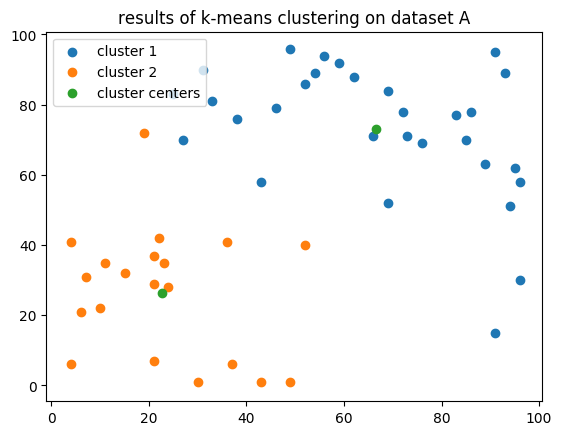

In [5]:
using PyPlot

C=zeros(sum(X[1,:]),2)
D=zeros(sum(X[2,:]),2)
c1=1
c2=1
for i=1:length(A[:,1])
    if X[1,i]==1
        C[c1,:]=A[i,:]
        c1=c1+1
    else
        D[c2,:]=A[i,:]
        c2=c2+1
    end
end
scatter(C[:,1],C[:,2],label="cluster 1")
scatter(D[:,1],D[:,2],label="cluster 2")
scatter(Y[:,1],Y[:,2],label="cluster centers")
legend(loc=2)
title("results of k-means clustering on dataset A");

### 2) Implementing a loss function -ISSUES

Here we will exemplary implement a simple loss function ourselves, just to illustrate the process. Suppose we want to implement our own version of a loss function like quadratic loss. We redefine the k-means function from above with our personal quad_loss instead of the provided one and apply the function to the same dataset to check that it works.

In [27]:
type my_quad_loss<:Loss
    scale::Float64
    domain::Domain
end
my_quad_loss(scale=1.0::Float64; domain=RealDomain()) = my_quad_loss(scale, domain)

evaluate(l::my_quad_loss, u::Float64, a::Number) = l.scale*(u-a)^2

grad(l::my_quad_loss, u::Float64, a::Number) = 2*(u-a)*l.scale

M_estimator(l::my_quad_loss, a::AbstractArray) = mean(a)


M_estimator (generic function with 2 methods)

In [24]:
evaluate(l::my_quad_loss, u::Float64, a::Int64) = l.scale*(u-a)^2

evaluate (generic function with 3 methods)

In [28]:
function fit_kmeans(A,k)
    n=size(A[1,:])
    m=size(A[:,1])
	loss = my_quad_loss()
	ry = ZeroReg()
	rx = UnitOneSparseConstraint()
	glrm = GLRM(A,loss,rx,ry,k)
	X,Y,ch = fit!(glrm)
	println("Convergence history:",ch.objective)
	return A,X,Y,ch
end

fit_kmeans (generic function with 1 method)

In [29]:
A,X,Y,ch=fit_kmeans(A,2)  # k specifies the number of clusters we want to group the data in 

Fitting GLRM


Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{Union{Int64, Range{Int64}}}, ::Int64) at ./deprecated.jl:57
 [3] get_yidxs(::Array{LowRankModels.Loss,1}) at /home/annika/JuliaProDir/JuliaPro-0.6.2.1/JuliaPro/pkgs-0.6.2.1/v0.6/LowRankModels/src/losses.jl:77
 [4] #fit!#79(::LowRankModels.ConvergenceHistory, ::Bool, ::Array{Any,1}, ::Function, ::LowRankModels.GLRM, ::LowRankModels.ProxGradParams) at /home/annika/JuliaProDir/JuliaPro-0.6.2.1/JuliaPro/pkgs-0.6.2.1/v0.6/LowRankModels/src/algorithms/proxgrad.jl:52
 [5] #fit!#76(::Array{Any,1}, ::Function, ::LowRankModels.GLRM) at /home/annika/JuliaProDir/JuliaPro-0.6.2.1/JuliaPro/pkgs-0.6.2.1/v0.6/LowRankModels/src/fit.jl:18
 [6] fit_kmeans(::Array{Int64,2}, ::Int64) at ./In[28]:8
 [7] include_string(::String, ::String) at ./loading.jl:522
 [8] include_string(::Module, ::String, ::String) at //////////////////////////////////////////////home/annika/JuliaProDir/JuliaPro-0.6.2.1/JuliaPro/pkgs-0.6.2.1/v0.6/Co

LoadError: [91mMethodError: no method matching evaluate(::my_quad_loss, ::Float64, ::Int64)[0m
Closest candidates are:
  evaluate([91m::LowRankModels.QuadLoss[39m, ::Float64, ::Number) at /home/annika/JuliaProDir/JuliaPro-0.6.2.1/JuliaPro/pkgs-0.6.2.1/v0.6/LowRankModels/src/losses.jl:137
  evaluate([91m::LowRankModels.L1Loss[39m, ::Float64, ::Number) at /home/annika/JuliaProDir/JuliaPro-0.6.2.1/JuliaPro/pkgs-0.6.2.1/v0.6/LowRankModels/src/losses.jl:151
  evaluate([91m::LowRankModels.HuberLoss[39m, ::Float64, ::Number) at /home/annika/JuliaProDir/JuliaPro-0.6.2.1/JuliaPro/pkgs-0.6.2.1/v0.6/LowRankModels/src/losses.jl:167
  ...[39m

### 3) Implementing a regulariser - ISSUES

Here we will exemplary implement a simple regulariser ourselves, just to illustrate the process. 

In [31]:
type my_nnconst<:Regularizer
end
prox(r::my_nnconst,u::AbstractArray,alpha::Number=1) = broadcast(max,u,0)
prox!(r::my_nnconst,u::Array{Float64},alpha::Number=1) = (@simd for i=1:length(u) @inbounds u[i] = max(u[i], 0) end; u)
function evaluate(r::my_nnconst,a::AbstractArray)
    for ai in a
        if ai<0
            return Inf
        end
    end
    return 0
end
scale(r::my_nnconst) = 1
scale!(r::my_nnconst, newscale::Number) = 1


scale! (generic function with 2 methods)

In [32]:
m,n,k = 100,100,5
losses = QuadLoss() # minimize squared distance to cluster centroids
rx = my_nnconst() # each row is assigned to exactly one cluster
ry = ZeroReg() # no regularization on the cluster centroids
glrm = GLRM(A,losses,rx,ry,k)

LowRankModels.GLRM([23 4; 9 98; … ; 98 75; 87 69], LowRankModels.Loss[LowRankModels.QuadLoss(1.0, LowRankModels.RealDomain()), LowRankModels.QuadLoss(1.0, LowRankModels.RealDomain())], my_nnconst(), LowRankModels.Regularizer[LowRankModels.ZeroReg(), LowRankModels.ZeroReg()], 5, UnitRange{Int64}[1:2, 1:2, 1:2, 1:2, 1:2, 1:2, 1:2, 1:2, 1:2, 1:2  …  1:2, 1:2, 1:2, 1:2, 1:2, 1:2, 1:2, 1:2, 1:2, 1:2], UnitRange{Int64}[1:50, 1:50], [-0.315504 -1.47361 … -2.21761 -0.267595; -1.50008 0.460724 … -0.421099 -0.677817; … ; -0.931368 -1.00003 … 0.323815 0.242194; -2.1075 -1.45362 … -0.384584 -2.16385], [-0.732209 0.18148; -0.0489664 -0.556019; … ; 0.596506 -0.854203; -1.52158 -0.560434])

In [33]:
X,Y,ch = fit!(glrm)

Fitting GLRM


Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{Union{Int64, Range{Int64}}}, ::Int64) at ./deprecated.jl:57
 [3] get_yidxs(::Array{LowRankModels.Loss,1}) at /home/annika/JuliaProDir/JuliaPro-0.6.2.1/JuliaPro/pkgs-0.6.2.1/v0.6/LowRankModels/src/losses.jl:77
 [4] #fit!#79(::LowRankModels.ConvergenceHistory, ::Bool, ::Array{Any,1}, ::Function, ::LowRankModels.GLRM, ::LowRankModels.ProxGradParams) at /home/annika/JuliaProDir/JuliaPro-0.6.2.1/JuliaPro/pkgs-0.6.2.1/v0.6/LowRankModels/src/algorithms/proxgrad.jl:52
 [5] #fit!#76(::Array{Any,1}, ::Function, ::LowRankModels.GLRM) at /home/annika/JuliaProDir/JuliaPro-0.6.2.1/JuliaPro/pkgs-0.6.2.1/v0.6/LowRankModels/src/fit.jl:18
 [6] fit!(::LowRankModels.GLRM) at /home/annika/JuliaProDir/JuliaPro-0.6.2.1/JuliaPro/pkgs-0.6.2.1/v0.6/LowRankModels/src/fit.jl:9
 [7] include_string(::String, ::String) at ./loading.jl:522
 [8] include_string(::Module, ::String, ::String) at //////////////////////////////////////////

LoadError: [91mMethodError: no method matching evaluate(::my_nnconst, ::ArrayViews.ContiguousView{Float64,1,Array{Float64,2}})[0m
Closest candidates are:
  evaluate([91m::LowRankModels.QuadReg[39m, ::AbstractArray) at /home/annika/JuliaProDir/JuliaPro-0.6.2.1/JuliaPro/pkgs-0.6.2.1/v0.6/LowRankModels/src/regularizers.jl:57
  evaluate([91m::LowRankModels.QuadConstraint[39m, ::AbstractArray) at /home/annika/JuliaProDir/JuliaPro-0.6.2.1/JuliaPro/pkgs-0.6.2.1/v0.6/LowRankModels/src/regularizers.jl:73
  evaluate([91m::LowRankModels.OneReg[39m, ::AbstractArray) at /home/annika/JuliaProDir/JuliaPro-0.6.2.1/JuliaPro/pkgs-0.6.2.1/v0.6/LowRankModels/src/regularizers.jl:87
  ...[39m

### 4) Application to data frames

GLRM work on dataframes, if these are of the specific type "DataFrame" provided in DataFrames.jl. The example below is taken from the github page. It takes a very long time to run. To achieve compatibility with Julia DB tables either the tables need to be converted in arrays or somehow transferred to the DataFrames structure.

In [49]:
import RDatasets
df = RDatasets.dataset("psych", "msq");

In [52]:
glrm, labels = GLRM(df, 3)
X, Y, ch = fit!(glrm)

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{LowRankModels.Loss}, ::Int64) at ./deprecated.jl:57
 [3] get_reals(::DataFrames.DataFrame) at /home/annika/JuliaProDir/JuliaPro-0.6.2.1/JuliaPro/pkgs-0.6.2.1/v0.6/LowRankModels/src/fit_dataframe_w_type_imputation.jl:46
 [4] #GLRM#111(::Array{LowRankModels.Loss,1}, ::LowRankModels.QuadReg, ::LowRankModels.QuadReg, ::Bool, ::Bool, ::Bool, ::Bool, ::Type{T} where T, ::DataFrames.DataFrame, ::Int64) at /home/annika/JuliaProDir/JuliaPro-0.6.2.1/JuliaPro/pkgs-0.6.2.1/v0.6/LowRankModels/src/fit_dataframe_w_type_imputation.jl:17
 [5] LowRankModels.GLRM(::DataFrames.DataFrame, ::Int64) at /home/annika/JuliaProDir/JuliaPro-0.6.2.1/JuliaPro/pkgs-0.6.2.1/v0.6/LowRankModels/src/fit_dataframe_w_type_imputation.jl:12
 [6] include_string(::String, ::String) at ./loading.jl:522
 [7] include_string(::Module, ::String, ::String) at //////////////////////////////////////////////home/annika/JuliaProDir/JuliaPro-0.6.2.1/Jul

Fitting GLRM


Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{Union{Int64, Range{Int64}}}, ::Int64) at ./deprecated.jl:57
 [3] get_yidxs(::Array{LowRankModels.Loss,1}) at /home/annika/JuliaProDir/JuliaPro-0.6.2.1/JuliaPro/pkgs-0.6.2.1/v0.6/LowRankModels/src/losses.jl:77
 [4] #fit!#79(::LowRankModels.ConvergenceHistory, ::Bool, ::Array{Any,1}, ::Function, ::LowRankModels.GLRM, ::LowRankModels.ProxGradParams) at /home/annika/JuliaProDir/JuliaPro-0.6.2.1/JuliaPro/pkgs-0.6.2.1/v0.6/LowRankModels/src/algorithms/proxgrad.jl:52
 [5] #fit!#76(::Array{Any,1}, ::Function, ::LowRankModels.GLRM) at /home/annika/JuliaProDir/JuliaPro-0.6.2.1/JuliaPro/pkgs-0.6.2.1/v0.6/LowRankModels/src/fit.jl:18
 [6] fit!(::LowRankModels.GLRM) at /home/annika/JuliaProDir/JuliaPro-0.6.2.1/JuliaPro/pkgs-0.6.2.1/v0.6/LowRankModels/src/fit.jl:9
 [7] include_string(::String, ::String) at ./loading.jl:522
 [8] include_string(::Module, ::String, ::String) at //////////////////////////////////////////

Iteration 10: objective value = 264923.0732885193
Iteration 20: objective value = 238757.4635960281
Iteration 30: objective value = 234403.69170629315
Iteration 40: objective value = 232189.25431921572
Iteration 50: objective value = 230690.07153050354
Iteration 60: objective value = 229531.6012084008


LoadError: [91mInterruptException:[39m

# Simple Benchmarking against Python

The authors of this package also provide a Python implementation (details can be found in the aforementioned paper). As this is very similar in strucutre we rather benchmark one of the standard methods against other implementations to see if they are comparable in speed. We choose to look at PCA and the speed of the implementation of of PCA as a GLRM with the implementation of Pythons sklearn. We fit to a randomly generated matrix A which has 100 features (columns) and 500 instances (rows). The Python implementation can found in the notebook "Python Examples Benchmarking" https://github.com/dominusmi/warwick-rsg/blob/master/Scouting/Python%20Examples%20Benchmarking.ipynb.

In [59]:
# minimize ||A - XY||^2
function fit_pca(m,n,k)
	# matrix to encode
	A = randn(m,k)*randn(k,n)
	loss = QuadLoss()
	r = ZeroReg()
	glrm = GLRM(A,loss,r,r,k)
	X,Y,ch = fit!(glrm)
	println("Convergence history:",ch.objective)
	return A,X,Y,ch
end


fit_pca (generic function with 1 method)

In [60]:
@elapsed(fit_pca(100,500,5))

Fitting GLRM


Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{Union{Int64, Range{Int64}}}, ::Int64) at ./deprecated.jl:57
 [3] get_yidxs(::Array{LowRankModels.Loss,1}) at /home/annika/JuliaProDir/JuliaPro-0.6.2.1/JuliaPro/pkgs-0.6.2.1/v0.6/LowRankModels/src/losses.jl:77
 [4] #fit!#79(::LowRankModels.ConvergenceHistory, ::Bool, ::Array{Any,1}, ::Function, ::LowRankModels.GLRM, ::LowRankModels.ProxGradParams) at /home/annika/JuliaProDir/JuliaPro-0.6.2.1/JuliaPro/pkgs-0.6.2.1/v0.6/LowRankModels/src/algorithms/proxgrad.jl:52
 [5] #fit!#76(::Array{Any,1}, ::Function, ::LowRankModels.GLRM) at /home/annika/JuliaProDir/JuliaPro-0.6.2.1/JuliaPro/pkgs-0.6.2.1/v0.6/LowRankModels/src/fit.jl:18
 [6] fit_pca(::Int64, ::Int64, ::Int64) at ./In[59]:8
 [7] include_string(::String, ::String) at ./loading.jl:522
 [8] include_string(::Module, ::String, ::String) at //////////////////////////////////////////////home/annika/JuliaProDir/JuliaPro-0.6.2.1/JuliaPro/pkgs-0.6.2.1/v0.6/Compa

Iteration 10: objective value = 740.1456995857707
Iteration 20: objective value = 1.069033417738775
Convergence history:[4.97936e5, 2.59311e5, 1.30526e5, 51466.2, 23121.7, 6549.98, 3086.39, 2354.37, 1874.22, 1547.68, 740.146, 461.197, 321.236, 231.273, 168.531, 122.107, 100.591, 93.8988, 16.441, 3.74834, 1.06903, 0.403239, 0.195207]


6.75521661

Compared to sklearn (which is wrapping around C), this implementation of PCA is much slower.

|      | Python  (sklearn)     | Julia (LowRankModels.jl)      |
| ------------|:-------------:|-----------|
|Time | 0.024205684661865234 | 6.75521661 |